To do:
* Write a class for preprocessing in a pipeline:
    * Add the option to remove the NOX variable.
    * Apply logarithm to PTRATIO, INDUS, and TAX.
* Use only top predictors (corr >= 0.5)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint
from math import ceil

import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import make_pipeline 

from sklearn.preprocessing import MinMaxScaler

/home/yamil/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/yamil/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [4]:
def rm_outliers_below(df, columns):
    """Returns its input dataframe without the lower outliers of the features given in the columns iterable."""
    df2 = df.copy()
    if type(df) == 'pandas.core.frame.DataFrame':
        for column in columns:
            Q1 = df2[column].quantile(0.25)
            Q3 = df2[column].quantile(0.75)
            mult = 1.5*(Q3-Q1)
            outlier_ix = df2[df2[column] <= Q1 - mult].index
            df2.drop(index=outlier_ix, inplace = True)
    elif type(df) == 'pandas.core.series.Series':
        Q1 = df2.quantile(0.25)
        Q3 = df2.quantile(0.75)
        mult = 1.5*(Q3-Q1)
        outlier_ix = df2[df2 <= Q1 - mult].index
        df2.drop(index=outlier_ix, inplace = True)
        
    return df2

In [5]:
def rm_outliers_above(df, columns):
    """Returns its input dataframe without the upper outliers of the features given in the columns iterable."""
    df2 = df.copy()
    for column in columns:
        if type(df) == 'pandas.core.frame.DataFrame':
            Q1 = df2[column].quantile(0.25)
            Q3 = df2[column].quantile(0.75)
            mult = 1.5*(Q3-Q1)
            outlier_ix = df2[df2[column] >= Q3 + mult].index
            df2.drop(index=outlier_ix, inplace = True)
        elif type(df) == 'pandas.core.series.Series':
            Q1 = df2.quantile(0.25)
            Q3 = df2.quantile(0.75)
            mult = 1.5*(Q3-Q1)
            outlier_ix = df2[df2 >= Q3 + mult].index
            df2.drop(index=outlier_ix, inplace = True)
        
    return df2

In [6]:
def reduce_skew(df):
    """Applies the logarithm to the columns with a skewness greater than 0.5 (not absolute value)."""
    df2 = df.copy()
    if type(df) == 'pandas.core.frame.DataFrame':
        for column in df.columns:
            if df2[column].skew() >= 0.5:
                df2[column] = np.log(df2[column])
    elif type(df) == 'pandas.core.series.Series':
        if df2.skew() >= 0.5:
                df2 = np.log(df2)
    
    return df2

In [7]:
class FeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, poly_features=None, max_degree=3, rm_outliers=None):
        self.poly_features = poly_features #List of features to make polynomial
        self.max_degree = max_degree #Maximum polynomial degree
        self.rm_outliers = rm_outliers #Features to remove upper outliers from
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_temp = X.copy()
        #Remove outliers
        if self.rm_outliers is not None:
            X_temp = rm_outliers_above(X_temp, self.rm_outliers)
        #Apply log to reduce skew
        X_temp = reduce_skew(X_temp)
        #Make polynomial features
        if self.poly_features is not None:
            poly_feat_transformer = PolynomialFeatures(degree=self.max_degree)
            X_temp = poly_feat_transformer.fit_transform(X_temp[self.poly_features])
        
        return X_temp

In [8]:
def pipeline_grid_search_eval( X_train, y_train, pipe, param_grid):
    """Runs the given datasets through a pipeline, performs a grid search and evaluates its performance through
    cross-validation and mean squared error.
    
    Arguments:
    -pipeline: Sklearn pipeline object. An ML model must be trained at some step in the pipe.
    -param_grid: List of dictionaries with the hyperparamaters to try in the grid search.
    -X_train: NumPy array with the features to be trained on.
    -y_train: NumPy array with the labels used to train and evaluate.
    
    Returns:
    search_res: The fit GridSearchCV
    """
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    search_res = grid_search.fit(X_train, y_train)
    
    best_cv_score = np.sqrt(-search_res.best_score_)
    best_cv_std = np.sqrt(search_res.cv_results_['std_test_score'][search_res.best_index_])
    best_model = search_res.best_estimator_
    best_y_hat = best_model.predict(X_train)
    best_train_score = np.sqrt(mean_squared_error(y_train, best_y_hat))
    best_train_std = np.std((y_train - best_y_hat)**2)
    
    pprint('Best paramaters:\n' + str(search_res.best_params_))
    print('\n')
    print('''CV error: %.2f +- %.2f
train error: %.2f +- %.2f
Label mean for comparison: %.2f'''%(best_cv_score, best_cv_std,
                                    best_train_score, best_train_std,
                                    y_train.mean()))
    
    return search_res

## Obtaining train and test sets

In [9]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

In [10]:
X_train.shape

(404, 13)

# First model

I'll apply a simple first model to get an idea of how it well it performs. I'll use all features with a correlation coefficient with the target greater than 0.5, except for the RAD variable due to its extremely high correlation with TAX.

In [11]:
X2 = pd.merge(X_train, y_train, left_index = True, right_index=True)

In [12]:
#Removing outliers from y2_train
#X2 = rm_outliers_above(X2, ['target'])
outlier_ix = X2[X2['target'] >= 50].index
X2.drop(index=outlier_ix, inplace=True)

In [13]:
predictors = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE', 'CRIM']
X2_train = X2[predictors].copy()
y2_train = X2['target'].copy()

In [14]:
X_feat_transformer = FeatureTransformer()
standard_scaler = StandardScaler()
l_reg = LinearRegression()
pipe = make_pipeline(X_feat_transformer,
    standard_scaler,
    l_reg
)
#X2_train_stand = scaler.fit_transform(X2_train)
#X2_train_stand = pd.DataFrame(X2_train_stand, columns=X2_train.columns)

In [15]:
#pipe.fit(X2_train, y2_train)

In [16]:
y2_train = np.log(y2_train)

In [17]:
cv_scores = cross_val_score(pipe, X2_train, y2_train, cv=5, scoring='neg_mean_squared_error')
cv_score = np.sqrt(-cv_scores.mean())
cv_std = cv_scores.std()

In [18]:
l_reg.fit(X2_train, y2_train)
train_score = np.sqrt(mean_squared_error(y2_train, l_reg.predict(X2_train)))

In [19]:
print('CV score: %.2f +/- %.2f\ntrain score: %.2f\nLabel mean for comparison: %.2f'%(cv_score, cv_std, train_score, y_train.mean()))

CV score: 0.19 +/- 0.01
train score: 0.18
Label mean for comparison: 22.80


Pretty good, but could be better. I'll try to engineer a couple of features next.

# Feature engineering

In [20]:
poly_features = [predictors]
param_grid = [
    {'feature_transformer__poly_features':poly_features,
     'feature_transformer__max_degree':list(range(2,5))
    }
]

In [21]:
pipe = Pipeline([
    ('feature_transformer', FeatureTransformer()),
    ('standardization', StandardScaler()),
    ('linear_reg', LinearRegression())
])

In [22]:
X2_train = X2[predictors].copy()

In [23]:
search_res = pipeline_grid_search_eval(X2_train, y2_train, pipe, param_grid)

('Best paramaters:\n'
 "{'feature_transformer__max_degree': 2, 'feature_transformer__poly_features': "
 "['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE', 'CRIM']}")


CV error: 0.34 +- 0.34
train error: 0.13 +- 0.04
Label mean for comparison: 3.02


With the new polynomial features, the train score diminished, but the CV score increased, meaning the model is overfitting. I'll try adding regularization.

In [24]:
from sklearn.linear_model import Ridge

In [25]:
reg_param_grid = [
    {'feature_transformer__poly_features':poly_features,
     'feature_transformer__max_degree':list(range(2,6)),
     'ridge_reg__alpha':np.arange(9,15)}
]

In [26]:
reg_pipe = Pipeline([
    ('feature_transformer', FeatureTransformer()),
    ('standardization', StandardScaler()),
    ('ridge_reg', Ridge())
])

In [27]:
search_res_reg = pipeline_grid_search_eval(X2_train, y2_train, reg_pipe, reg_param_grid)

('Best paramaters:\n'
 "{'feature_transformer__max_degree': 4, 'feature_transformer__poly_features': "
 "['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE', 'CRIM'], "
 "'ridge_reg__alpha': 11}")


CV error: 0.16 +- 0.07
train error: 0.12 +- 0.04
Label mean for comparison: 3.02


It improved. Let's see if a different model makes it even better.

# Support vector regressor

In [28]:
svr_pipe = Pipeline([
    ('feature_transformer', FeatureTransformer()),
    ('standardization', StandardScaler()),
    ('SVR', SVR())
])

#Defining a new parameter grid for the SVR
svr_param_grid = [
    {'SVR__gamma':np.arange(1,11),
     'SVR__C':np.arange(10,21),
     'SVR__kernel':['linear','rbf']}
]

In [29]:
#search_res_svr = pipeline_grid_search_eval(X2_train, y2_train, svr_pipe, svr_param_grid)

This one performs worse than the linear model.

# Linear regression analysis

From the two models, the regularized polynomial regression performed best. I'll analyze the residuals to check that the OLS assumptions are being met.

In [30]:
search_res_reg.best_params_

{'feature_transformer__max_degree': 4,
 'feature_transformer__poly_features': ['LSTAT',
  'INDUS',
  'NOX',
  'PTRATIO',
  'RM',
  'TAX',
  'DIS',
  'AGE',
  'CRIM'],
 'ridge_reg__alpha': 11}

In [31]:
best_model = search_res_reg.best_estimator_

In [32]:
best_model = Pipeline([
    ('feature_transformer', FeatureTransformer(max_degree=4, poly_features=X2_train.columns)),
    ('standardization', StandardScaler()),
    ('ridge_reg', Ridge(alpha=11))
])

In [33]:
best_model.fit(X2_train, y2_train)

Pipeline(steps=[('feature_transformer',
                 FeatureTransformer(max_degree=4,
                                    poly_features=Index(['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE', 'CRIM'], dtype='object'))),
                ('standardization', StandardScaler()),
                ('ridge_reg', Ridge(alpha=11))])

In [34]:
y2_hat = np.exp(best_model.predict(X2_train)) #Remember a log was applied

In [35]:
resid = y2_hat - np.exp(y2_train)

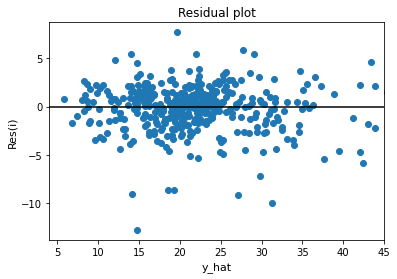

In [36]:
xmin = 4
xmax = 45
plt.scatter(y2_hat, resid.values)
plt.xlim(xmin, xmax)
plt.title('Residual plot')
plt.xlabel('y_hat', fontsize=11)
plt.ylabel('Res(i)', fontsize=11)
plt.hlines(0, xmin=xmin, xmax=xmax);

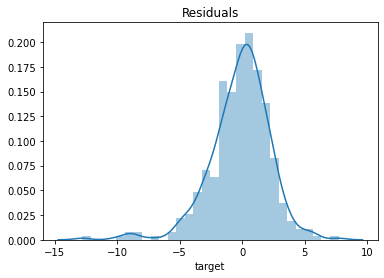

In [37]:
sns.distplot(resid, bins=30)
plt.title('Residuals');

In [38]:
from statsmodels.graphics.gofplots import qqplot

In [39]:
from scipy.stats.distributions import norm

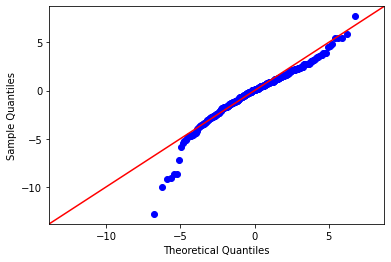

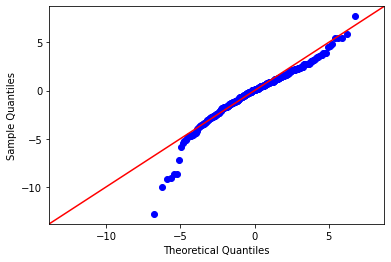

In [40]:
qqplot(resid, line='45', dist = norm(scale=resid.std()))

Beyond a couple of outliers, the residual distribution looks pretty good.

# Decision tree regressor

In [41]:
from sklearn.tree import DecisionTreeRegressor

In [43]:
X2_train.shape

(391, 9)

In [47]:
tree_pipe = Pipeline([
    ('feature_transformer', FeatureTransformer()),
    ('standardization', StandardScaler()),
    ('tree', DecisionTreeRegressor(random_state=42))
])

#It's important to regularize decision trees. I'll search for the op
tree_param_grid = [
    {'tree__max_depth':list(range(1,11)),
     'tree__min_samples_leaf':list(range(10,41,5))}
]

In [48]:
search_res_reg = pipeline_grid_search_eval(X2_train, y2_train, tree_pipe, tree_param_grid)

"Best paramaters:\n{'tree__max_depth': 5, 'tree__min_samples_leaf': 20}"


CV error: 0.19 +- 0.07
train error: 0.17 +- 0.06
Label mean for comparison: 3.02


# Performance on test set

In [56]:
best_model.fit(X2_train, y2_train)

Pipeline(steps=[('feature_transformer',
                 FeatureTransformer(max_degree=4,
                                    poly_features=Index(['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE', 'CRIM'], dtype='object'))),
                ('standardization', StandardScaler()),
                ('ridge_reg', Ridge(alpha=11))])

In [66]:
y_hat_test = best_model.predict(X_test).reshape((-1,1))

In [72]:
test_error = np.sqrt(mean_squared_error(np.log(y_test), best_model.predict(X_test)))
test_std = np.std((np.log(y_test) - y_hat_test)**2)

In [73]:
print("""CV error: 0.15 +- 0.07
train error: 0.12 +- 0.03
test error: %.2f +- %.2f
Label mean for comparison: 3.07"""%(test_error, test_std))

CV error: 0.15 +- 0.07
train error: 0.12 +- 0.03
test error: 0.16 +- 0.07
Label mean for comparison: 3.07


In [ ]:
best_cv_score = np.sqrt(-search_res.best_score_)
best_cv_std = np.sqrt(search_res.cv_results_['std_test_score'][search_res.best_index_])
best_model = search_res.best_estimator_
best_y_hat = best_model.predict(X_train)
best_train_score = np.sqrt(mean_squared_error(y_train, best_y_hat))
best_train_std = np.std((y_train - best_y_hat)**2)

In [77]:
cv_error_real = np.exp(0.15)
cv_std_real = np.exp(0.07)
train_error_real = np.exp(0.12)
train_std_real = np.exp(0.03)
test_error_real = np.exp(test_error)
test_std_real = np.exp(test_std)
label_mean_real = np.exp(3.07)

In [78]:
print("""CV error: %.2f +- %.2f
train error: %.2f +- %.2f
test error: %.2f +- %.2f
Label mean for comparison: %.2f"""%(cv_error_real, cv_std_real,
                                    train_error_real, train_std_real,
                                    test_error_real, test_std_real,
                                   label_mean_real))

CV error: 1.16 +- 1.07
train error: 1.13 +- 1.03
test error: 1.18 +- 1.07
Label mean for comparison: 21.54


So the model can predict the price, whose mean value is of \\$21.54k, while making an error of approximately \\$1K +- \\$1K.